# Latent Space VIsualization

In [6]:
from across.BioTac_Signal_Reconstruction.src.datasets.data_loader import BioTacDataPreperation
import numpy as np

data_module = BioTacDataPreperation(
        ["../Data/datasets/BioTac_Pure_Exp_Dataset_v1.0/biotac1.hdf5",
         "../Data/datasets/BioTac_Pure_Exp_Dataset_v1.0/biotac3.hdf5",
         "../Data/datasets/biotac_single_contact_response/ruppel_flat_in_nvidia_reduced.hdf5",
         "../Data/datasets/biotac_single_contact_response/ruppel_stick_in_nvidia_reduced.hdf5"
         ], test_data_path="../Data/datasets/BioTac_Pure_Exp_Dataset_v1.0/biotac2.hdf5", batch_size=1, indenter_filter=None)
data_module.prepare_data()
data_module.setup(0)
norms = np.array([data_module.mean, data_module.std])
print(norms)
#np.save("./value_norms.npy", norms)

validation_dataset = data_module.val_data

Train set size: 179706
Test set size: 8561
Val set size: 59903
[[-4.94144370e-03 -1.58457987e-02 -1.11950537e-02 -2.66732774e-03
  -5.88686525e-03  1.29954492e-03 -7.12192280e-03 -7.87310904e-03
  -7.34667872e-03 -8.25397532e-03 -7.70217457e-06 -1.49601628e-02
  -9.65099868e-03  2.03783803e-03 -2.26069423e-03  8.68125712e-03
  -1.43700224e-02 -5.88719546e-03 -5.56070370e-05]
 [ 5.15507319e-02  5.49720475e-02  4.59747270e-02  5.36548360e-02
   4.07424241e-02  5.33975020e-02  1.75189264e-02  1.91305325e-02
   1.96548463e-02  1.65373878e-02  5.75105676e-02  5.92391798e-02
   4.57846152e-02  4.53949280e-02  3.26702774e-02  3.44033964e-02
   3.36382927e-02  2.69880068e-02  2.49182354e-02]]


In [7]:
from src.model.biotac_autoencoder import BioTacAutoencoder
from pathlib import Path

model = BioTacAutoencoder.load_from_checkpoint(Path("../Data/checkpoints/biotac_signal_reconstruction/all_data/epoch=99-step=70200.ckpt").resolve())
model.eval()

BioTacAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=19, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=19, bias=False)
  )
  (mu_layer): Linear(in_features=64, out_features=8, bias=False)
  (log_var_layer): Linear(in_features=64, out_features=8, bias=False)
)

In [8]:
inp = validation_dataset[:][0]
print(inp)
inp = inp.to(model.device)
latent_spaces = model.forward(inp)[0]

np_latent_spaces = latent_spaces.cpu().detach().numpy()

print(np_latent_spaces.shape)
maximum_latent = np_latent_spaces.max(axis=0)
minimum_latent = np_latent_spaces.min(axis=0)

dist_lat = (minimum_latent - maximum_latent) / np_latent_spaces.shape[1]
print(maximum_latent)
print(dist_lat)

tensor([[ 0.5364,  0.3727,  0.3391,  ...,  0.3909,  0.2634,  0.0806],
        [-0.5058,  0.3016,  0.2541,  ...,  0.5942,  0.3901,  0.1982],
        [-0.8942,  0.0928,  0.0948,  ...,  0.3401,  0.1367, -0.0860],
        ...,
        [ 0.5838,  0.5237,  0.5091,  ...,  0.6087, -0.0352, -0.4486],
        [ 0.2948,  0.3416,  0.3657,  ...,  0.5869,  0.5348,  0.4530],
        [-0.1694,  0.2394,  0.2116,  ...,  0.4345,  0.2543,  0.0610]])
(59903, 8)
[15.650633   5.4687386  9.556892   6.4414654  4.5316243  4.2822037
 10.251319  10.139745 ]
[-3.0176842 -2.3400989 -2.1881475 -1.5455241 -1.139627  -1.067117
 -2.186368  -1.8320763]


In [10]:
import torch

res = {}
for i in range(np_latent_spaces.shape[1]):
    tmp = np.zeros(maximum_latent.shape[0], dtype=float)
    tmp[i] = maximum_latent[i]
    for k in range(np_latent_spaces.shape[1]):
        tmp[i] += dist_lat[i]
        print(tmp)
        inp = torch.tensor(tmp, device="cuda:0", dtype=torch.float)
        recon = model.decode(inp.unsqueeze(0))
        res[(i, k)] = recon.cpu().detach().numpy()

print(res.keys())
print(res[(0,0)].shape)
print(res)

[12.63294864  0.          0.          0.          0.          0.
  0.          0.        ]
[9.61526442 0.         0.         0.         0.         0.
 0.         0.        ]
[6.59758019 0.         0.         0.         0.         0.
 0.         0.        ]
[3.57989597 0.         0.         0.         0.         0.
 0.         0.        ]
[0.56221175 0.         0.         0.         0.         0.
 0.         0.        ]
[-2.45547247  0.          0.          0.          0.          0.
  0.          0.        ]
[-5.47315669  0.          0.          0.          0.          0.
  0.          0.        ]
[-8.49084091  0.          0.          0.          0.          0.
  0.          0.        ]
[0.        3.1286397 0.        0.        0.        0.        0.
 0.       ]
[0.         0.78854084 0.         0.         0.         0.
 0.         0.        ]
[ 0.         -1.55155802  0.          0.          0.          0.
  0.          0.        ]
[ 0.         -3.89165688  0.          0.          0.  

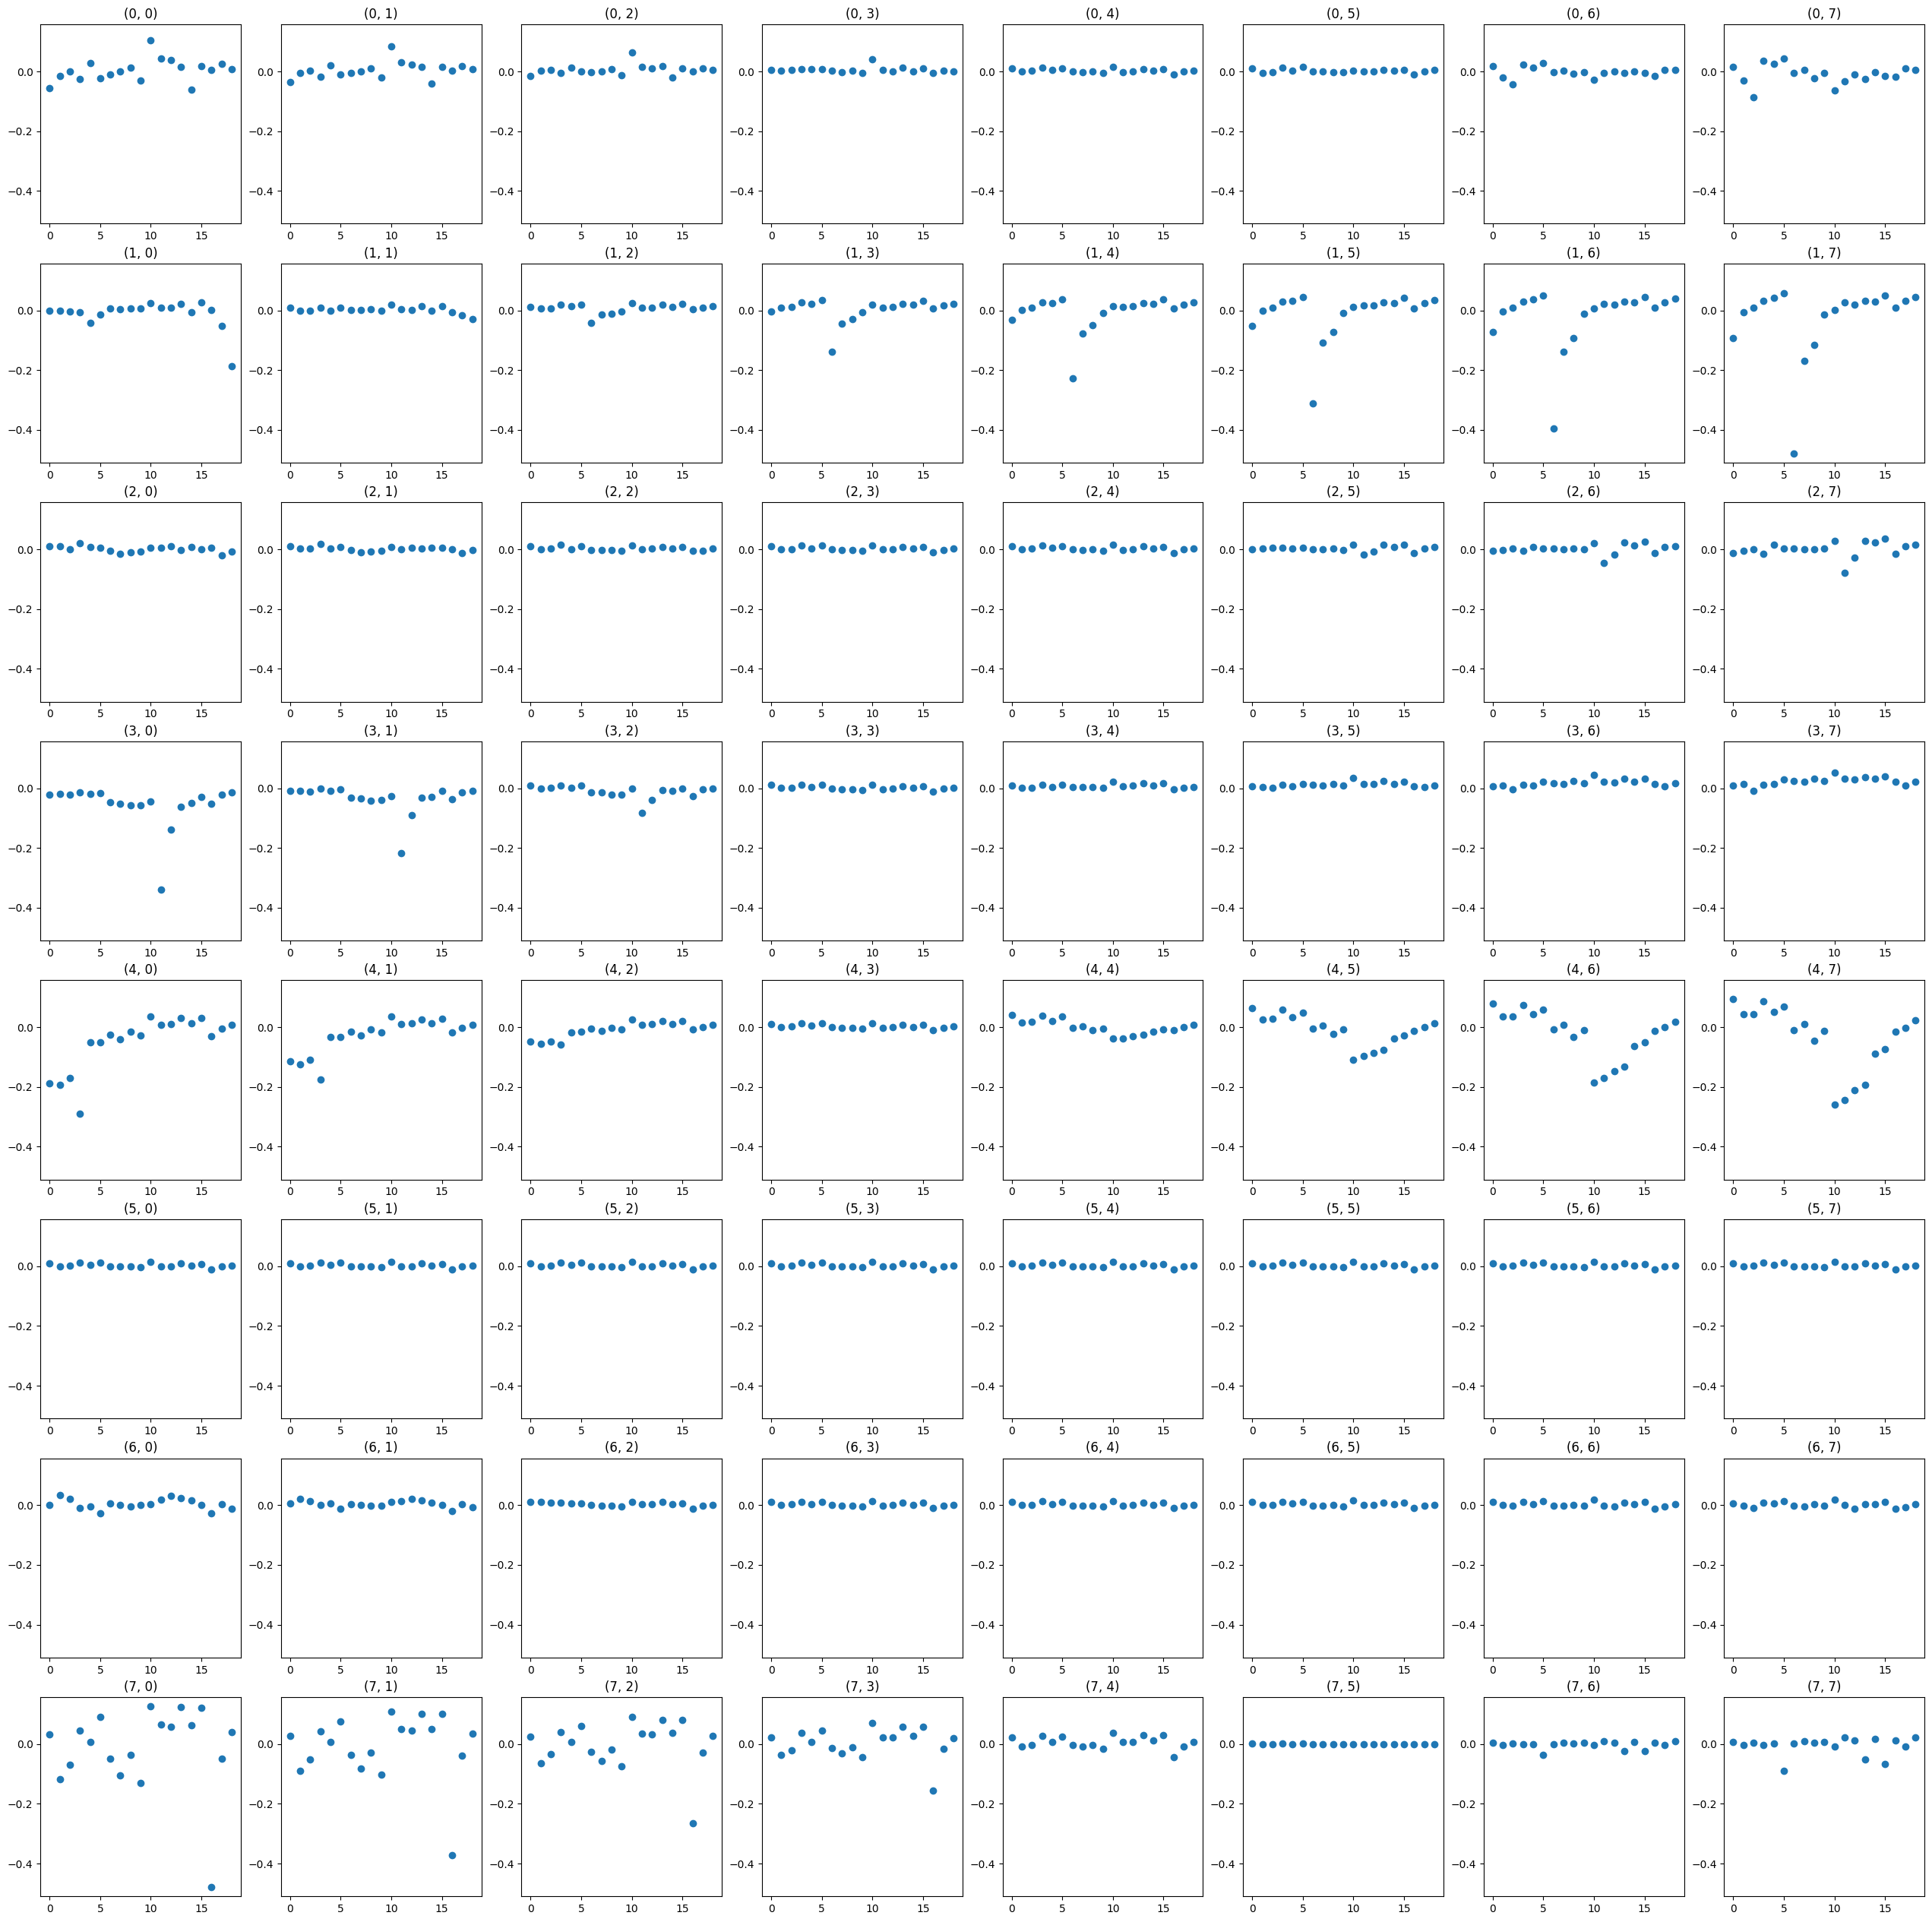

In [11]:
import matplotlib.pyplot as plt
import numpy as np

index = 1

fig = plt.figure(figsize=(32, 32))

ticks = [-1, -0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
ax = None
for i in range(np_latent_spaces.shape[1]):
    for k in range(np_latent_spaces.shape[1]):
        if ax is not None:
            ax = fig.add_subplot(np_latent_spaces.shape[1], np_latent_spaces.shape[1], index, sharex=ax, sharey=ax)
        else: 
            ax = fig.add_subplot(np_latent_spaces.shape[1], np_latent_spaces.shape[1], index)
        ax.yaxis.set_ticks(ticks)
        ax.set_title(f"{(i,k)}")
        index += 1
        points = res[(i, k)][0] * data_module.std + data_module.mean
        ax.scatter(np.arange(points.shape[0]), points)

plt.show()